In [28]:
import os
import cv2
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MotorcycleDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None, exclude_categories=None, target_size=(512, 512)):
        self.img_dir = img_dir
        self.transform = transform
        self.exclude_categories = exclude_categories if exclude_categories is not None else []
        self.target_size = target_size # 이미지 리사이즈를 위한 목표 크기 추가

        # 1. JSON 불러오기
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        # 2. 이미지 정보와 어노테이션 매핑
        self.images = {img['id']: img for img in self.data['images']}
        self.img_ids = list(self.images.keys())

        # 3. 이미지 ID별로 어노테이션 그룹화
        self.annotations = {}
        for ann in self.data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 1. 이미지 로드
        img_id = self.img_ids[idx]
        file_name = self.images[img_id]['file_name']
        img_path = os.path.join(self.img_dir, file_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_h, original_w = image.shape[0], image.shape[1]

        # 이미지 리사이즈
        if self.target_size is not None:
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)

        # 2. 빈 마스크 생성 (리사이즈된 이미지와 동일한 크기)
        h, w = self.target_size if self.target_size is not None else (original_h, original_w)
        mask = np.zeros((h, w), dtype=np.uint8)

        # 3. 좌표 데이터를 마스크에 칠하기
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                if ann.get('category_id') in self.exclude_categories:
                    continue

                for seg in ann['segmentation']:
                    if not isinstance(seg, list) or len(seg) < 6:
                        continue

                    poly = np.array(seg).reshape(-1, 2).astype(np.float32)

                    # 원본 이미지 크기 대비 리사이즈 비율 적용하여 폴리곤 좌표 조정
                    scale_x = w / original_w
                    scale_y = h / original_h
                    poly[:, 0] = poly[:, 0] * scale_x
                    poly[:, 1] = poly[:, 1] * scale_y
                    poly = poly.astype(np.int32)

                    if len(poly) < 3:
                        continue

                    cv2.fillPoly(mask, [poly], 1)

        # 4. 파이토치 텐서로 변환
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()

        return image, mask

In [29]:
json_path = "/content/drive/MyDrive/Colab Notebooks/data/Motorcycle/COCO_motorcycle (pixel).json"
images_path = "/content/drive/MyDrive/Colab Notebooks/data/Motorcycle/images"

# 'Undrivable' 카테고리 (ID: 1323880)를 제외하고 데이터셋 생성
exclude_category_ids = [1323880]
# 이미지 크기를 (512, 512)로 리사이즈하여 데이터셋 생성
dataset = MotorcycleDataset(json_path, images_path, exclude_categories=exclude_category_ids, target_size=(512, 512))
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # batch_size를 2에서 1로 줄였습니다.

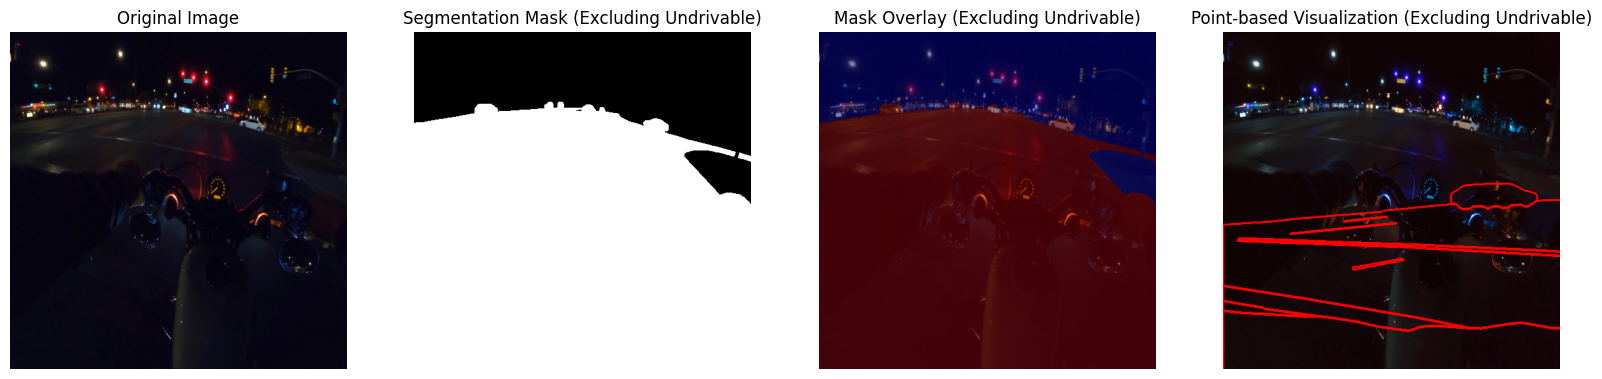

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 # For drawing circles

# 1. 데이터셋에서 첫 번째 샘플 가져오기 (이미지 자체는 원본을 사용)
image, mask = dataset[0] # The image here is normalized [0,1] and tensor.
image_show = image.permute(1, 2, 0).numpy() # Convert to HWC, RGB, numpy array [0,1]
original_image_display = (image_show * 255).astype(np.uint8) # Convert back to 0-255 for cv2 operations and display
mask_show = mask.numpy() # mask_show 변수 정의 추가

# 2. 점 기반 시각화를 위한 이미지 복사
points_image = original_image_display.copy()

# 3. 첫 번째 이미지의 원본 어노테이션 데이터 가져오기
first_img_id = dataset.img_ids[0]
annotations_for_first_image = dataset.annotations.get(first_img_id, [])

# 4. 'Undrivable' 카테고리를 제외하고 점 그리기
exclude_category_id = 1323880 # Defined in the plan

for ann in annotations_for_first_image:
    if ann.get('category_id') == exclude_category_id:
        continue # 'Undrivable' 카테고리는 제외

    if 'segmentation' in ann and ann['segmentation']:
        for seg in ann['segmentation']:
            # COCO Segmentation 포맷은 [x1, y1, x2, y2, ...] 형태의 플랫 리스트
            # 유효한 폴리곤을 그려면 최소 3개의 점 (6개의 좌표)이 필요합니다.
            if not isinstance(seg, list) or len(seg) < 6:
                continue

            # 폴리곤 좌표를 (x, y) 쌍으로 변환
            # cv2.circle을 사용하기 위해 각 점에 대해 반복합니다.
            for i in range(0, len(seg), 2):
                x, y = int(seg[i]), int(seg[i+1])
                # 점을 빨간색으로 표시 (BGR 형식, cv2는 BGR을 사용)
                # cv2.circle(image, center, radius, color, thickness)
                cv2.circle(points_image, (x, y), 1, (0, 0, 255), -1) # radius 1, filled circle

# 5. 그래프 그리기
plt.figure(figsize=(20, 5))

# 원본 이미지
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_image_display) # Display original 0-255 image
plt.axis('off')

# 생성된 마스크 (정답)
plt.subplot(1, 4, 2)
plt.title("Segmentation Mask (Excluding Undrivable)")
plt.imshow(mask_show, cmap='gray')
plt.axis('off')

# 원본 위에 마스크 겹치기 (오버레이)
plt.subplot(1, 4, 3)
plt.title("Mask Overlay (Excluding Undrivable)")
plt.imshow(original_image_display) # Display original 0-255 image
plt.imshow(mask_show, alpha=0.5, cmap='jet') # alpha로 투명도 조절
plt.axis('off')

# 점 기반 시각화
plt.subplot(1, 4, 4)
plt.title("Point-based Visualization (Excluding Undrivable)")
# cv2.circle은 BGR로 그리기 때문에, matplotlib으로 표시하려면 RGB로 변환해야 함
plt.imshow(cv2.cvtColor(points_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [38]:
# !pip install segmentation_models_pytorch

import torch.nn as nn
import segmentation_models_pytorch as smp

# U-Net 선택.
model = smp.Unet(
    encoder_name="resnet18",        # 특징 추출기 (resnet34에서 resnet18로 변경하여 메모리 사용량 줄임)
    encoder_weights="imagenet",     # 사전 학습된 가중치 사용
    in_channels=3,                  # 입력 이미지 채널 (RGB)
    classes=6,                      # 출력 클래스 수 (PDF 설명서 기준 6개 클래스)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # 모델을 GPU로 이동
print(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

cuda


In [39]:
import torch.optim as optim
from torch.cuda.amp import GradScaler # GradScaler import

# 다중 클래스 분류를 위한 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 모델의 가중치를 업데이트할 옵티마이저 (학습률 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# AMP GradScaler 초기화
scaler = GradScaler()

/tmp/ipython-input-1893591265.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [40]:
from torch.cuda.amp import autocast # autocast import

epochs = 10 # 전체 데이터를 몇 번 반복해서 학습할지

for epoch in range(epochs):
    model.train() # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 각 epoch 시작 시 GPU 캐시 메모리 비우기
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    for images, masks in dataloader: # 아까 만든 데이터로더에서 묶음(Batch)씩 가져옴
        images = images.to(device)
        masks = masks.to(device)

        # 1. 경사(Gradient) 초기화
        optimizer.zero_grad()

        # 2. 모델 예측 (Forward) 및 오차 계산 (Loss) - autocast context manager 사용
        with autocast(): # mixed precision 활성화
            outputs = model(images)
            loss = criterion(outputs, masks)

        # 3. 역전파 (Backward) - GradScaler 사용
        scaler.scale(loss).backward() # loss를 스케일링하여 역전파

        # 4. 가중치 업데이트 (Step) - GradScaler 사용
        scaler.step(optimizer) # 스케일링된 그라디언트로 옵티마이저 업데이트
        scaler.update() # 다음 반복을 위해 스케일러 업데이트

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("학습 완료!")

/tmp/ipython-input-4266684376.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # mixed precision 활성화
/tmp/ipython-input-4266684376.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # mixed precision 활성화


Epoch [1/10], Loss: 0.3764
Epoch [2/10], Loss: 0.1828
Epoch [3/10], Loss: 0.1649
Epoch [4/10], Loss: 0.1589
Epoch [5/10], Loss: 0.1364
Epoch [6/10], Loss: 0.1269
Epoch [7/10], Loss: 0.1109
Epoch [8/10], Loss: 0.1078
Epoch [9/10], Loss: 0.0988
Epoch [10/10], Loss: 0.1180
학습 완료!


In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
else:
    print("GPU를 사용할 수 없습니다.")